## **Quickstart Guide**

This guide covers a simple workflow to help you get started with twinLab. In this notebook, we will perform the following steps:

1. Upload a dataset to the twinLab cloud.
2. Use `Emulator.train` to train a surrogate model.
3. Use the emulator to make a prediction with `Emulator.predict`.
4. Visualise the results and their uncertainty.


In [ ]:
# Third-party imports
import numpy as np
import pandas as pd

# Project imports
import twinlab as tl

### **Set your API Key**

If you don't already have one, please vist [https://www.digilab.co.uk/contact](https://www.digilab.co.uk/contact). For security, we normally recommend performing this step with a `.env` file or `secrets`.


In [20]:
tl.set_api_key("REPLACE_THIS_WITH_YOUR_API_KEY")

### **1. Upload a dataset to twinLab**

Your dataset must be presented as a `pandas.DataFrame` object, or a filepath which points to a `csv` file that can be parsed to a `pandas.DataFrame` object. **The dataset must be formatted with clearly labelled columns.** In `twinlab`, data is expected to be in column-feature format, meaning each row represents a single data sample, and each column represents a data feature, also known as a parameter.

`twinLab` contains a `Dataset` class with attributes and methods to process, view and summarise the dataset. Datasets must be created with an `id` which is used to access them. The dataset can be uploaded using the `upload` method.

In twinLab, we provide some example datasets to helps user get started (see `tl.list_example_datasets` for a list). Here we use the example `quickstart` dataset, which has a single input (feature/predictor/parameter) variable `x` and a single output (response) variable `y`.


In [2]:
# Download the example dataset
df = tl.load_example_dataset("quickstart")

# Check the dataframe before uploading
display(df)

# Intialise a Dataset object and give it a name
dataset = tl.Dataset("quickstart")

# Upload the dataset, passing in the dataframe
dataset.upload(df)

,x,y
0,0.696469,-0.817374
1,0.286139,0.887656
2,0.226851,0.921553
3,0.551315,-0.326334
4,0.719469,-0.832518
5,0.423106,0.400669
6,0.980764,-0.164966
7,0.684830,-0.960764
8,0.480932,0.340115
9,0.392118,0.845795


/Users/saiaakashramesh/twinLab/client/python/twinlab/utils.py:90: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not df.applymap(lambda x: isinstance(x, (int, float))).all().all():


### **2. Train an emulator**

The `Emulator` class is used to train and implement your surrogate models. As with datasets, an `id` is defined, which is a unique ID under which your emulator will be saved as in the cloud.

When training an emulator, optional arguments are passed in using a `TrainParams` object. `TrainParams` contains parameters you can tweak when training your model - you can find the defaults in the documentation.

To train the emulator we use the `Emulator.train` method, passing in the `TrainParams` object as an argument.


In [3]:
# Initialise emulator
emulator = tl.Emulator("quickstart-model")

# Define the training parameters for the emulator.
# For example, here we set the train_test_ratio to 1, meaning that the entire dataset will be used for training.
params = tl.TrainParams(train_test_ratio=1.0)

# Train the mulator using the train method
emulator.train(dataset=dataset, inputs=["x"], outputs=["y"], params=params)

### **3. Make Predictions using the Trained Emulator**

The surrogate model is now trained and saved to the cloud under the `id` specified above. It can now be used to make predictions.

You'll need a dataset of inputs for which you want to find the corresponding outputs. Ensure that this is a `pandas.DataFrame` object. Then call `Emulator.predict`, with the evaluation dataset as the keyword argument.


In [4]:
# We'll define some example inputs for the dataset
x_predict = np.linspace(0, 1, 11)

# And convert them to a DataFrame
df_predict = pd.DataFrame({"x": x_predict})

# Now we'll predict the results.
# This returns a tuple of two dataframes:
# 1. The mean prediction corresponding to each input
# 2. The standard deviation corresponding to each input
predictions_mean, predictions_std = emulator.predict(df_predict)

# Write the predictions to the screen
print("Mean predictions:")
display(predictions_mean)
print("Standard deviation predictions:")
display(predictions_std)

Mean predictions:


,y
0,0.618116
1,0.766788
2,0.891405
3,0.908986
4,0.669546
5,0.090804
6,-0.567991
7,-0.863546
8,-0.733036
9,-0.420330


Standard deviation predictions:


,y
0,0.653885
1,0.424600
2,0.202528
3,0.161307
4,0.153866
5,0.156232
6,0.170339
7,0.149920
8,0.233575
9,0.243088


In [5]:
# Let's merge these into a single dataframe...
result_df = pd.concat([df_predict, predictions_mean, predictions_std], axis="columns")

# ...and rename the columns to make the contents of the output clear
result_df.columns = ["x to predict", "predicted mean y", "predicted std y"]

# Let's have a look!
display(result_df)

,x to predict,predicted mean y,predicted std y
0,0.0,0.618116,0.653885
1,0.1,0.766788,0.424600
2,0.2,0.891405,0.202528
3,0.3,0.908986,0.161307
4,0.4,0.669546,0.153866
5,0.5,0.090804,0.156232
6,0.6,-0.567991,0.170339
7,0.7,-0.863546,0.149920
8,0.8,-0.733036,0.233575
9,0.9,-0.420330,0.243088


### **4. Viewing the Results**

`Emulator.predict` outputs mean values for each input and their standard deviation. Using `Emulator.plot`, we can nicely visualise the uncertainty in our results. 

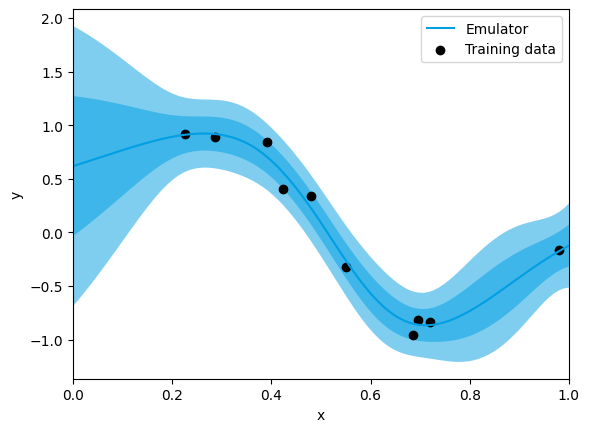

In [6]:
# Plot results
plt = emulator.plot(x_axis="x", y_axis="y", x_lim=(0, 1.0))
plt.scatter(df["x"], df["y"], color="black", label="Training data")
plt.legend()
plt.show()

### **5. Sampling from the Emulator**

`Emulator.sample` allows us to sample a number of functions from the trained emulator. This comes with an important parameter, `observation_noise`, that can be defined through the `SampleParams` object. This will help us to sample functions from the emulator that account for the inherent noise in the observations or otherwise.

First, we will try to sample without the `observation_noise`, which is the default setting. Then, we will sample with the `observation_noise`, and visualise how different the sampled functions are.

Note: There is an `observation_noise` parameter in `PredictParams` as well. This is used when making predictions with a trained emulator. The default value of `observation_noise` is true in this case. This means, when making predictions, we account for the noise in the observations by default. Therefore we can expect the default noise levels when making predictions, versus sampling, are different.


In [7]:
# A function to plot multiple samples from the model
def plot_samples(sample_inputs, sample_result):
    # Plot parameters
    color_curve = "blue"
    alpha_curve = 0.10
    color_data = "black"
    plot_training_data = True
    plot_model_bands = False

    # Plot samples drawn from the model
    if plot_training_data:
        plt.plot(df["x"], df["y"], ".", color=color_data, label="Training data")
    plt.plot(sample_inputs, sample_result["y"], color=color_curve, alpha=alpha_curve)
    plt.xlim((0.0, 1.0))
    plt.xlabel(r"$X$")
    plt.ylabel(r"$y$")
    plt.legend()
    plt.show()

In [8]:
# Define the sample inputs
sample_inputs = pd.DataFrame({"x": np.linspace(0, 1, 128)})

# Define number of samples to calculate for each input
num_samples = 100

# Calculate the samples using twinLab
sample_result = emulator.sample(sample_inputs, num_samples)

# View the results in the form of a dataframe
display(sample_result)

y                                                              \
            0         1         2         3         4         5         6   
0    0.622822  0.914916  0.622322  1.410007  0.453206  1.206967  0.709584   
1    0.616252  0.891304  0.638816  1.408798  0.448352  1.216886  0.684312   
2    0.613551  0.869275  0.655329  1.406716  0.445294  1.222496  0.662106   
3    0.614900  0.850190  0.670959  1.403281  0.444239  1.224616  0.642764   
4    0.619276  0.834461  0.686106  1.395665  0.444333  1.223468  0.625735   
..        ...       ...       ...       ...       ...       ...       ...   
123 -0.168425 -0.291622 -0.258929 -0.224006  0.068956 -0.096450 -0.040633   
124 -0.105983 -0.306689 -0.229030 -0.204014  0.076632 -0.086668 -0.016756   
125 -0.045133 -0.323577 -0.197536 -0.182700  0.080005 -0.078937  0.000777   
126  0.014904 -0.340794 -0.165003 -0.158985  0.079781 -0.073732  0.012436   
127  0.076264 -0.358164 -0.132695 -0.133868  0.075979 -0.070150  0.018911   

                                   ...                                \
            7         8         9  ...        90        91        92   
0    0.698610  0.347506  0.361059  ...  1.218708  0.929694  0.353181   
1    0.741080  0.354371  0.375057  ...  1.178038  0.957826  0.374714   
2    0.781659  0.360060  0.392113  ...  1.136571  0.988627  0.398282   
3    0.820606  0.365538  0.410077  ...  1.095023  1.018840  0.424109   
4    0.856584  0.372718  0.428043  ...  1.053460  1.047616  0.453263   
..        ...       ...       ...  ...       ...       ...       ...   
123 -0.375368 -0.250154 -0.282849  ... -0.109662 -0.316059 -0.171631   
124 -0.321579 -0.208379 -0.256054  ... -0.055444 -0.294280 -0.196020   
125 -0.264137 -0.165237 -0.230798  ... -0.003623 -0.272584 -0.223184   
126 -0.204742 -0.123331 -0.206690  ...  0.046667 -0.251910 -0.252698   
127 -0.143719 -0.084190 -0.183760  ...  0.096231 -0.232643 -0.282613   

                                                                           
           93        94        95        96        97        98        99  
0    0.363303 -0.694344  0.362586 -0.262959  0.475557  0.431218  0.603147  
1    0.378974 -0.616385  0.352263 -0.271303  0.494142  0.463236  0.610198  
2    0.397904 -0.537043  0.343497 -0.278926  0.510042  0.493131  0.621078  
3    0.420111 -0.458645  0.336062 -0.283006  0.523482  0.521027  0.635358  
4    0.447316 -0.383866  0.329910 -0.283638  0.536361  0.548809  0.651582  
..        ...       ...       ...       ...       ...       ...       ...  
123 -0.143412 -0.131942 -0.113261 -0.307966 -0.011753 -0.135099 -0.088909  
124 -0.132499 -0.107631 -0.115315 -0.259606  0.003869 -0.084946 -0.077716  
125 -0.126307 -0.086052 -0.118368 -0.209710  0.014230 -0.034554 -0.065497  
126 -0.122769 -0.065197 -0.120759 -0.159865  0.019399  0.014927 -0.053004  
127 -0.121446 -0.044494 -0.121392 -0.111542  0.019398  0.061720 -0.039540  

[128 rows x 100 columns]

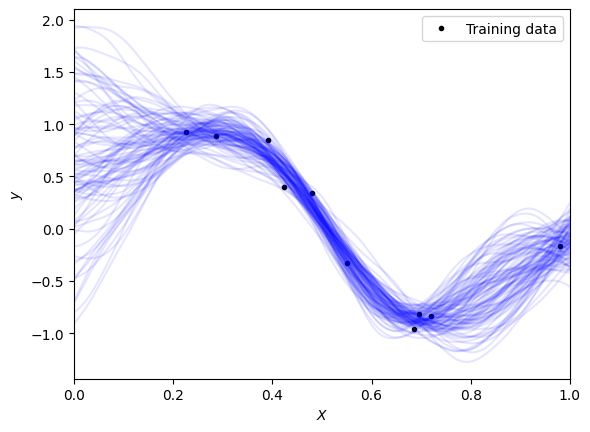

In [9]:
# Plot the samples
plot_samples(sample_inputs, sample_result)

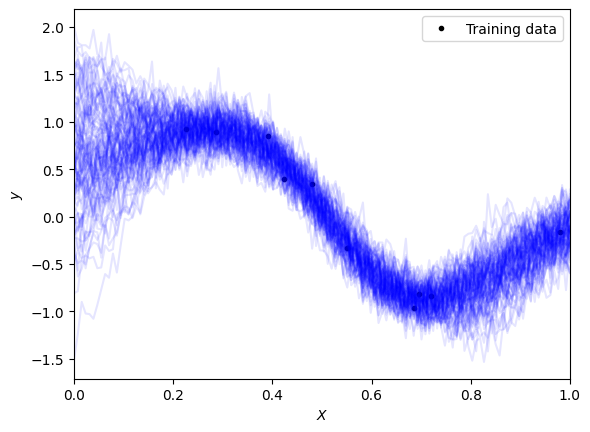

In [10]:
# Set observation_noise to True
sample_params = tl.SampleParams(observation_noise=True)

# Sample from the emulator
sample_result_1 = emulator.sample(sample_inputs, num_samples, params=sample_params)

# Plot the samples
plot_samples(sample_inputs, sample_result_1)

It can be observed that, if the `observation_noise` parameter is set to `True`, the individual samples are noisy. This can be attributed to the independenet noise present in every data point. The samples are much smoother if we do not account for the noise in the observation; i.e when `observation_noise = False`.


### **Deleting datasets and campaigns**

You can delete your datasets and emulators. Please be aware that this is permanent. Always consider keeping your data backed-up. `Emulator.delete` and `Dataset.delete` delete the emulator and the dataset respectively.


In [11]:
# Delete the emulator
emulator.delete()

# Delete the dataset
dataset.delete()